In [55]:
import random
import copy
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [56]:
class Dataset:
    def __init__(self,X,y,proportion=0.8,shuffle=True, mini_batch=0):
        """
        :param X: ndarray
                    feature data
        :param y: labels
        :param proportion: number between 0 and 1
        :param shuffle: boolean, whether apply data shuffle
        """
        self.X = X
        self.y = y
        self.trainset = None
        self.testset = None
        self.validationset = None
        self.proportion = proportion
        self.shuffle = shuffle
        self.mini_batch = mini_batch
        self.allset = np.concatenate((X,y),axis=1)
        self.minisets = []

        if self.shuffle:
            # automatic distribution
            self.distribute()

        # generate subsets respect mini batch
        if self.mini_batch !=0:
            self.getminiset()
    # @classmethod
    # def imageset(cls, path, proportion = 0.8, shuffle = None):
    #     pass

    def distribute(self):
        """
        This function will automatically distribute train and test dataset
        """
        n = np.shape(self.X)[0]
        samples = np.concatenate((self.X,self.y),axis=1)
        random.shuffle(samples)
        # sample train and test dataset
        self.trainset = samples[0:round(n*self.proportion),:]
        self.testset = samples[round(n*self.proportion)+1:, :]

    def getX(self):
        return self.X

    def gety(self):
        return self.y

    def getminibatch(self):
        return self.mini_batch

    def gettrainset(self):
        """
        :return: return train dataset with respect of proportion
        """
        return Dataset(self.trainset[:, 0:self.X.shape[1]], self.trainset[:, self.X.shape[1]:])

    def gettestset(self):
        """
        :return: test dataset with respect of proportion
        """
        return Dataset(self.testset[:, 0:self.X.shape[1]], self.testset[:, self.X.shape[1]:])

    def getminiset(self):
        spilit_list = np.arange(self.mini_batch, self.allset.shape[0], self.mini_batch)
        minisets = np.split(self.allset, spilit_list)
        for i in range(len(minisets)):
            self.minisets.append(Dataset(minisets[i][:, 0:self.X.shape[1]], minisets[i][:, self.X.shape[1]:],shuffle =False))


In [57]:

class NN:
    import numpy as np
    def __init__(self,dataset):
        """
        :param dataset:
        """
        # self.input = input
        self.dataset = dataset
        self.layer_list = []

    def addlayers(self,layers):
        self.layer_list = layers

    def getlayers(self):
        return self.layer_list

    # activation functions
    class ActivationFunc:
        @staticmethod
        def sigmoid(x):
            """
            Sigmoid function
            """
            return 1.0 / (1.0 + np.exp(-x))

        @staticmethod
        def ReLU(x):
            return np.maximum(0, x)

        @staticmethod
        def LeakyReLU(x):
            return  np.where(x > 0, x, x * 0.01)

        @staticmethod
        def tanh(x):
            return np.tanh(x)

        @staticmethod
        def none(x):
            return x

    # Layer class
    class Layer:
        def __init__(self, type, input_dim, output_dim, activation):
            """
            :param type: Layer type, choose 'Linear', 'Conv' etc
            :param input_dim: input dim or previous layer's output
            :param output_dim: output dim of this layer
            :param activation: activation function, 'none' for no activation
            """
            self.type = type
            self.input_dim = input_dim
            self.output_dim = output_dim
            self.activation = activation

        def getinputdim(self):
            return self.input_dim

        def getoutputdim(self):
            return self.output_dim

        def gettype(self):
            return self.type

        def getact(self, x):
            func_name = "NN.ActivationFunc."+self.activation
            func = eval(func_name)
            return func(x)

        def getactname(self):
            return self.activation

    class LinearLayer(Layer):
        def __init__(self, input_dim, output_dim):
            self.type = "Linear"
            self.input_dim = input_dim
            self.output_dim = output_dim


    class Conv2DLayer(Layer):
        def __init__(self, image_size, kernel_size, stride, padding):
            self.type = "Conv2D"
            self.image_size = image_size
            self.kernel_size = kernel_size
            self.stride = stride
            self.padding = padding

        def getimagesize(self):
            return self.image_size

        def getkernelsize(self):
            return self.kernel_size

        def getstride(self):
            return self.stride

        def getpadding(self):
            return self.padding

    class BN(Layer):
        def __init__(self):
            self.type = "BN"
            self.activation ="none"

In [58]:
class Optimizer:
    def __init__(self,nn,optimizer,batch_size=8,epoch=20000,lr=0.0001):
        """
        :param nn: input an NN class
        :param optimizer: optimizer as "GD", "SGD" etc
        :param batch_size: batch size for mini batch optimization
        :param epoch: epoch number
        :param lr: learning rate
        """

        self.nn = nn
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epoch = epoch
        self.lr = lr
        self.weight_list = None
        self.gradient_list = None
        self.loss_list = None
        self.passer_list = None

    class LossFunc:
        @staticmethod
        def log_loss(y_true, y_pred, eps=1e-16):
            """
            Loss function we would like to optimize (minimize)
            We are using Logarithmic Loss
            http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss
            """
            y_pred = np.maximum(y_pred,eps)
            y_pred = np.minimum(y_pred,(1-eps))
            return -(np.sum(y_true * np.log(y_pred)) + np.sum((1-y_true)*np.log(1-y_pred)))/len(y_true)

        @staticmethod
        def quadra_loss(y_true, y_pred):
            return 0.5*np.sum((y_pred-y_true)**2)

    class Node:
        def __init__(self, data,type):
            self.left = None
            self.right = None
            self.data = data
            self.type = type
            self.back = None

        def getleft(self):
            return self.left

        def getright(self):
            return self.right

        def gettype(self):
            return self.type

        def getdata(self):
            return  self.data

        def getback(self):
            return  self.back

    def getgradientlist(self):
        return self.gradient_list

    def getlosslist(self):
        return self.loss_list

    def getweightlist(self):
        return self.weight_list

    class WeightIni:
        @staticmethod
        def init_linear_weight(input_dim, output_dim):
            return np.random.uniform(-1, 1, (input_dim, output_dim))

        @staticmethod
        def init_BN_weight(x):
            gamma = np.sqrt(np.var(x))
            beta = np.mean(x)
            return gamma, beta

        @staticmethod
        def init_conv2D_kernel(shape):
            """
            :param shape: shape of kernel
            :return:
            """
            return np.random.random(shape)

        @staticmethod
        def initial_weight_list(layer_list):
            weight_list = []
            # initial weights in weight list by their type
            for layer in layer_list:
                # linear weight operation
                if layer.gettype() == "Linear":
                    weight_list.append(Optimizer.Node(Optimizer.WeightIni.init_linear_weight(layer.getinputdim(), layer.getoutputdim()),"weight"))
                elif layer.gettype() == "BN":
                    gamma, beta = Optimizer.WeightIni.init_BN_weight(X.getdata())
                    weight_list.append(Optimizer.Node((gamma, beta),"weight"))
                # kernel parse operation
                elif layer.gettype() == "Conv2D":
                    weight_list.append(Optimizer.Node(Optimizer.WeightIni.init_conv2D_kernel(layer.getkernelsize()),"weight"))
                else:
                    return  NameError
            return weight_list

    @staticmethod
    def forword(passer, weight_list, layer_list):
        layer_num = len(layer_list)
        passer_list = [Optimizer.Node(passer, "data")]
        for i in range(layer_num):
            if layer_list[i].gettype() =='Linear':

                passer = passer@weight_list[i].getdata()
                # append binary tree after inner product of weight and previous layer
                node = Optimizer.Node(passer,"inner_product")
                node.left = passer_list[-1]
                node.right = weight_list[i]
                passer_list.append(node)

                passer = layer_list[i].getact(passer)
                #append binary tree after activation function
                node = Optimizer.Node(passer,layer_list[i].getactname())
                node.left = passer_list[-1]
                passer_list.append(node)

            elif layer_list[i].gettype() == "BN":
                # batch_mean = np.mean(passer)
                # batch_var = np.var(passer)
                passer = np.linalg.norm(passer)

                passer = weight_list[i].getdata()[0] * passer
                node = Optimizer.Node(passer,"inner_product")
                node.left = passer_list[-1]
                passer_list.append(node)

                passer = passer + weight_list[i].getdata()[1]
                node = Optimizer.Node(passer,"plus")
                node.left = passer_list[-1]
                passer_list.append(node)
            # elif layer_list[j].gettype() == "Conv2D":
            else: raise NameError
        return passer_list

    @staticmethod
    def backpropagation(node):
        if node.getleft() is not None:
            if node.gettype() == "inner_product":
                node.getleft().back = node.getback()@node.getright().getdata().T
                node.getright().back = node.getleft().getdata().T@node.getback()
            elif node.gettype() == "sigmoid":
                # node.getleft().back = np.multiply(node.getback(),np.multiply(NN.ActivationFunc.sigmoid(node.getback()),
                #                                                              (np.ones(node.getback().shape))-NN.ActivationFunc.sigmoid(node.getback())))
                node.getleft().back = np.multiply(node.getback(),np.multiply(NN.ActivationFunc.sigmoid(node.getback()),
                                                                             1-NN.ActivationFunc.sigmoid(node.getback())))
            elif node.gettype() == "ReLU":
                back = copy.deepcopy(node.getback())
                back[back<=0] = 0
                node.getleft().back = back
            elif node.gettype() == "LeakyReLU":
                back = copy.deepcopy(node.getback())
                back[back<0] = 0.01*back[back<0]
                node.getleft().back = back
            elif node.gettype() == "tanh":
                node.getleft().back = np.multiply((np.ones(node.getback().shape)-NN.ActivationFunc.tanh(node.getback())**2),
                                                  node.getback())
                # node.getleft().back = (np.ones(node.getback().shape)-NN.ActivationFunc.tanh(node.getback())**2)
            elif node.gettype() == "plus":
                node.getleft().back = node.getback()
                node.getright().back = node.getback()
            elif node.gettype() == "minus":
                node.getleft().back = node.getback()
                node.getright().back = -node.getback()
            elif node.gettype() == "none":
                node.getleft().back = node.getback()

            Optimizer.backpropagation(node.getleft())
        else:
            return

    def GD(self, root, weight_list):
        root.back = 2 * (-self.nn.dataset.gettrainset().gety() + root.getdata())
        Optimizer.backpropagation(root)
        gradient_list = []

        for node in weight_list:
            node.data = node.data - self.lr * node.back
            gradient_list.append(node.back)
        return weight_list, gradient_list

    def SGD(self, weight_list, passer_list):
        # we resume mini-batch equals 1 each time
        """
        :param root:
        :param weight_list:
        :param passer_list:
        :return:
        """
        def init_random_node(node, random_num_list, mini_weight_list):
            node.data = node.data[random_num_list,:]
            node.back = None
            if node.getright() is not None:
                mini_weight_list.append(node.getright())
            if node.getleft() is not None:
                init_random_node(node.getleft(), random_num_list, mini_weight_list)
            else: return

        # obs = observation number = output layer's dim 0
        num_obs = self.nn.dataset.gettrainset().getX().shape[0]
        mini_passer_list = copy.deepcopy(passer_list)
        root = mini_passer_list[-1]
        gradient_list = []

        # randomly pick observations from original obs
        random_num_list = np.random.randint(0, num_obs, num_obs)

        # initial random node
        mini_weight_list = []
        init_random_node(root, random_num_list, mini_weight_list)

        # back propagation
        root.back = 2 * (- self.nn.dataset.gettrainset().gety()[random_num_list] + root.getdata()[random_num_list])
        Optimizer.backpropagation(root)

        i = 0
        # update weight list
        for weight in weight_list:
            weight.data = weight.data - self.lr * mini_weight_list[-i-1].back
            gradient_list.append(mini_weight_list[-i-1].back)
            i = i + 1

        return weight_list, gradient_list

    def minibatchgd(self, weight_list, passer_list):
        minisets = self.nn.dataset.getminiset()



        def init_random_node(node, random_num_list, mini_weight_list):
            node.data = node.data[random_num_list,:]
            node.back = None
            if node.getright() is not None:
                mini_weight_list.append(node.getright())
            if node.getleft() is not None:
                init_random_node(node.getleft(), random_num_list, mini_weight_list)
            else: return

        # obs = observation number = output layer's dim 0
        num_obs = self.nn.dataset.gettrainset().getX().shape[0]
        mini_passer_list = copy.deepcopy(passer_list)
        root = mini_passer_list[-1]
        gradient_list = []

        # randomly pick observations from original obs
        random_num_list = np.random.randint(0, num_obs, num_obs)

        # initial random node
        mini_weight_list = []
        init_random_node(root, random_num_list, mini_weight_list)

        # back propagation
        root.back = 2 * (- self.nn.dataset.gettrainset().gety()[random_num_list] + root.getdata()[random_num_list])
        Optimizer.backpropagation(root)

        i = 0
        # update weight list
        for weight in weight_list:
            weight.data = weight.data - self.lr * mini_weight_list[-i-1].back
            gradient_list.append(mini_weight_list[-i-1].back)
            i = i + 1

        return weight_list, gradient_list

    def train(self):
        layer_list = self.nn.getlayers()
        layer_num = len(layer_list)

        # initial weight, loss and gradient list
        X = self.nn.dataset.gettrainset().getX()
        X = Optimizer.Node(X, "data")
        self.weight_list = [[] for i in range(self.epoch+1)]
        self.weight_list[0] = Optimizer.WeightIni.initial_weight_list(layer_list)
        self.loss_list = np.zeros(self.epoch)
        self.gradient_list = [[] for i in range(self.epoch)]
        self.passer_list = [[] for i in range(self.epoch)]


        if self.optimizer =="GD" or self.optimizer == "SGD":
            for i in range(self.epoch):
                # forward propagation
                self.passer_list[i] = Optimizer.forword(X.getdata(), self.weight_list[i],layer_list)
                root = self.passer_list[i][-1]

                # calculate loss by using: loss2 * (-self.nn.dataset.gettrainset().gety() + root.getdata())
                self.loss_list[i] = Optimizer.LossFunc.quadra_loss(self.nn.dataset.gettrainset().gety(),root.getdata())

                # upgrade gradient by selected optimizer
                if self.optimizer =="GD":
                    self.weight_list[i+1], self.gradient_list[i] = Optimizer.GD(self, root, self.weight_list[i])

                elif self.optimizer =="SGD":
                    self.weight_list[i+1], self.gradient_list[i]  = Optimizer.SGD(self, self.weight_list[i], self.passer_list[i])

        elif self.optimizer =="minibatchgd":
            pass




In [59]:
class Visual:
    def __init__(self, optim):
        self.optim = optim

    def plotloss(self):
        """
        :return: plot loss flow during the training
        """
        plt.style.use('seaborn-whitegrid')
        fig = plt.figure()
        ax = plt.axes()
        ax.plot(self.optim.loss_list, label = 'loss')
        ax.legend(loc='upper right')
        ax.set_ylabel('Loss during the training')

    def plotgradientnorm(self):
        plt.style.use('seaborn-whitegrid')
        fig, axs = plt.subplots(len(self.optim.getgradientlist()[0]))
        for i in range(len(self.optim.getgradientlist()[0])):
            gradient_norm_list = []
            for j in range(len(self.optim.getgradientlist())):
                gradient_norm_list.append(np.linalg.norm(self.optim.getgradientlist()[j][i]))
            axs[i].plot(gradient_norm_list, label = 'norm 2')
            axs[i].legend(loc='upper right')
            axs[i].set_ylabel('W' + str(i) +" norm")


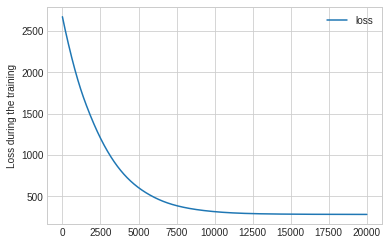

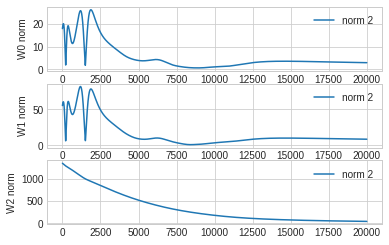

In [60]:
# total observation number
n = 200
# x1, x2 are generated by two
x1 = np.random.uniform(0,1,n)
x2 = np.random.uniform(0,1,n)
const = np.ones(n)
eps = np.random.normal(0,.05,n)
b = 1.5
theta1 = 2
theta2 = 5
Theta = np.array([b, theta1, theta2])
y = np.array(b * const+ theta1 * x1 + theta2 * x2 + eps)
y=np.reshape(y,(-1,1))
X = np.array([const,x1,x2]).T

layer_list = [NN.Layer('Linear',3,10,'sigmoid'),NN.Layer('Linear',10,3,'sigmoid'),
              NN.Layer('Linear',3,1,'none')]
dataset = Dataset(X, y)
nn = NN(dataset)
nn.addlayers(layer_list)
optim = Optimizer(nn,"GD",epoch = 20000, lr=1e-6)
optim.train()
visual = Visual(optim)
visual.plotloss()
visual.plotgradientnorm()